In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal, Tuple, Dict, List
# Chinese in labels
plt.rcParams['font.sans-serif'] = ['SimHei']


In [2]:
def loan_calculator(
    A: float,
    r_annual: float,
    N_years: int,
    method: Literal['equal_installment', 'equal_principal'] = 'equal_installment',
    output_freq: Literal['m', 'y'] = 'y'
) -> Tuple[Dict, List[Dict]]:
    """
    计算贷款还款计划的函数（增强版）
    新增功能：
    - 输出月均/年均还款额
    - 自动计算不同频率的参考还款
    """
    # 参数转换
    periods = N_years * (12 if output_freq == 'm' else 1)
    r_period = r_annual / (12 if output_freq == 'm' else 1)
    
    # 计算还款计划
    if method == 'equal_installment':
        # 等额本息计算
        if r_period == 0:
            installment = A / periods
        else:
            installment = A * r_period * (1 + r_period)**periods / ((1 + r_period)**periods - 1)
        
        schedule = []
        remaining = A
        total_interest = 0
        
        for i in range(1, periods + 1):
            interest = remaining * r_period
            principal = installment - interest
            remaining -= principal
            total_interest += interest
            
            schedule.append({
                'period': i,
                'payment': installment,
                'principal': principal,
                'interest': interest,
                'remaining': max(remaining, 0)
            })
        
        total_payment = installment * periods
        
    else:  # 等额本金
        principal_payment = A / periods
        schedule = []
        remaining = A
        total_interest = 0
        
        for i in range(1, periods + 1):
            interest = remaining * r_period
            payment = principal_payment + interest
            remaining -= principal_payment
            total_interest += interest
            
            schedule.append({
                'period': i,
                'payment': payment,
                'principal': principal_payment,
                'interest': interest,
                'remaining': max(remaining, 0)
            })
        
        total_payment = A + total_interest
    
    # 计算参考还款额（自动补充不同频率）
    monthly_ref = installment if output_freq == 'm' else \
                 (A * (r_annual/12) * (1 + r_annual/12)**(N_years*12)) / ((1 + r_annual/12)**(N_years*12) - 1)
    
    yearly_ref = installment if output_freq == 'y' else \
                monthly_ref * 12 if method == 'equal_installment' else sum(x['payment'] for x in schedule[:12])

    # 构建摘要信息
    summary = {
        'principal': A,
        'annual_rate': r_annual,
        'years': N_years,
        'method': method,
        'output_freq': output_freq,
        'total_payment': total_payment,
        'total_interest': total_interest,
        'total_principal': A,
        'effective_rate': total_interest / A,
        'period_payment': installment if output_freq == 'm' else yearly_ref,  # 当前输出频率的每期还款
        'monthly_payment': monthly_ref if output_freq == 'y' else installment,  # 补充月供参考
        'yearly_payment': yearly_ref  # 补充年供参考
    }
    
    return summary, schedule

In [3]:
def plot_loan_schedule(
    schedule: List[Dict],
    summary: Dict = None,
    show_params: bool = True,
    show_totals: bool = True,
    show_pie: bool = False,
    figsize: Tuple[int, int] = (14, 6)
) -> plt.Figure:
    """
    可视化贷款还款计划（统一右侧布局版）
    改进点：
    - 所有附加元素统一右侧布局
    - 饼图颜色与柱状图一致
    - 添加月均/年均还款信息
    """
    # 设置中文字体和样式
    plt.style.use('ggplot')
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 更美观的中文字体
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建画布（为右侧留出35%空间）
    fig = plt.figure(figsize=(figsize[0], figsize[1]))
    ax = fig.add_axes([0.1, 0.1, 0.55, 0.8])  # 主图占55%宽度
    
    # 提取数据
    periods = [x['period'] for x in schedule]
    principals = [x['principal'] for x in schedule]
    interests = [x['interest'] for x in schedule]
    
    # 设置统一颜色
    color_principal = '#4E79A7'  # 本金颜色
    color_interest = '#E15759'   # 利息颜色
    
    # 绘制堆叠柱状图
    p1 = ax.bar(periods, principals, label='本金', color=color_principal)
    p2 = ax.bar(periods, interests, bottom=principals, label='利息', color=color_interest)
    
    # 设置刻度标签
    ax.set_xticks(periods)
    ax.set_xlabel('还款年份' if summary['output_freq'] == 'y' else '还款月份')
    ax.set_ylabel('还款金额（元）')
    ax.set_title('贷款还款计划明细', pad=20)
    
    # 右侧信息面板（统一位置）
    right_panel = fig.add_axes([0.68, 0.1, 0.3, 0.8])
    right_panel.axis('off')  # 隐藏坐标轴
    
    # 添加还款信息表格
    info_text = []
    if show_params:
        info_text.extend([
            f"▌贷款参数",
            f"本金: {summary['principal']:,.0f}元",
            f"年利率: {summary['annual_rate']*100:.2f}%",
            f"期限: {summary['years']}年",
            f"方式: {'等额本息' if summary['method'] == 'equal_installment' else '等额本金'}",
            f"频率: {'按月' if summary['output_freq'] == 'm' else '按年'}"
        ])
    
    if show_totals:
        info_text.extend([
            "\n▌还款总额",
            f"总还款: {summary['total_payment']:,.0f}元",
            f"总利息: {summary['total_interest']:,.0f}元",
            f"利息占比: {summary['total_interest']/summary['total_payment']*100:.1f}%"
        ])
    
    # 添加参考还款信息
    if summary['output_freq'] == 'y':
        info_text.extend([
            "\n▌参考月供",
            f"月均还款: {summary['monthly_payment']:,.0f}元"
        ])
    else:
        info_text.extend([
            "\n▌参考年供",
            f"年均还款: {summary['yearly_payment']:,.0f}元"
        ])
    
    right_panel.text(0, 0.95, "\n".join(info_text), 
                    ha='left', va='top', linespacing=1.8,
                    bbox=dict(boxstyle='round', facecolor='#F7F7F7', alpha=0.9))
    
    # 添加饼图（颜色与主图一致）
    if show_pie:
        pie_ax = fig.add_axes([0.75, 0.1, 0.25, 0.4])
        labels = ['本金', '利息']
        sizes = [summary['principal'], summary['total_interest']]
        
        wedges, _, autotexts = pie_ax.pie(
            sizes, labels=labels, 
            colors=[color_principal, color_interest],
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops=dict(width=0.4, edgecolor='w')
        )
        
        pie_ax.set_title('还款构成比例', pad=20)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    
    plt.tight_layout()
    return fig

贷款摘要:
principal: 300000
annual_rate: 0.0285
years: 20
method: equal_installment
output_freq: y
total_payment: 397722.036484402
total_interest: 97722.03648440166
total_principal: 300000
effective_rate: 0.3257401216146722
period_payment: 19886.101824220103
monthly_payment: 1641.3561973314356
yearly_payment: 19886.101824220103


C:\Users\boson\AppData\Local\Temp\ipykernel_28984\143090978.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


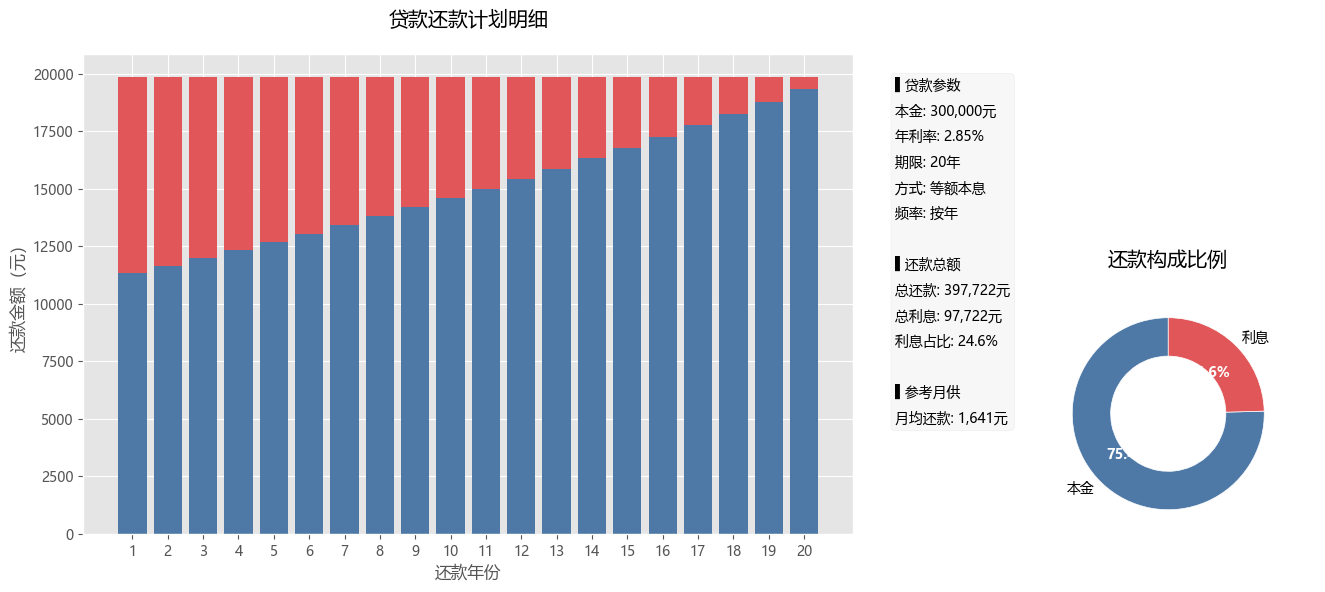

In [5]:


# 计算贷款
summary, schedule = loan_calculator(
    A=300000,  # 100万贷款
    r_annual=0.0285,  # 公积金首套房贷款利率
    N_years=20,  # 20年期限
    method='equal_installment',  # 等额本息
    output_freq='y'  # 按年输出
)

# 打印摘要
print("贷款摘要:")
for k, v in summary.items():
    print(f"{k}: {v}")

# 可视化
fig = plot_loan_schedule(schedule, summary, show_params=True, show_totals=True, show_pie=True)
plt.show()